<a href="https://colab.research.google.com/github/gabrxelle/Grupo-96---Tech-Challenge-FIAP/blob/main/Tech_Challenge_Ibovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTANDO BIBLIOTECAS

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree
from sklearn import tree
from sklearn.inspection import permutation_importance

# ANALISE EXPLORATÓRIA

In [148]:
df = pd.read_csv("Dados Históricos - Ibovespa.csv")

In [149]:
# Visualizando primeiras linhas do dataframe
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,18.07.2025,133.382,135.562,135.562,133.296,"10,07B","-1,61%"
1,17.07.2025,135.565,135.515,135.792,135.016,"6,80B","0,04%"
2,16.07.2025,135.511,135.250,135.641,134.265,"7,83B","0,19%"
3,15.07.2025,135.250,135.298,136.022,134.380,"6,90B","-0,04%"
4,14.07.2025,135.299,136.187,136.187,134.840,"7,33B","-0,65%"


In [150]:
# Visualizando informações das colunas do dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4954 non-null   object 
 1   Último    4954 non-null   float64
 2   Abertura  4954 non-null   float64
 3   Máxima    4954 non-null   float64
 4   Mínima    4954 non-null   float64
 5   Vol.      4953 non-null   object 
 6   Var%      4954 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.1+ KB


In [151]:
# Verificando se existem dados nulos
df.isnull().sum()

,0
Data,0
Último,0
Abertura,0
Máxima,0
Mínima,0
Vol.,1
Var%,0


In [152]:
# Removendo linha com volume vazio
df = df[~df['Vol.'].isnull()]

In [153]:
# Verificando se na coluna de volume existe outra unidade de medida além de bilhões
set(df['Vol.'].str[-1])

{'B', 'K', 'M'}

In [154]:
# Convertemos em data
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)

# Criando coluna de mês/ano
df['MesAno'] = pd.to_datetime(df['Data'].dt.strftime('%Y-%m'))

# Criando nova coluna com o ano
df['Ano'] = df['Data'].dt.year

# Transformando coluna de data em index e ordenando
df.set_index('Data', inplace=True)
df.sort_index(inplace=True)

In [155]:
# Limpeza e formatação dos dados de volume e numéricos
# A coluna 'Vol.' pode estar em formato de string como '12,34M'.
def converter_volume(vol_str):
    vol_str = str(vol_str).strip().upper()
    if 'M' in vol_str:
        return float(vol_str.replace('M', '').replace(',', '.')) * 1_000_000
    elif 'K' in vol_str:
        return float(vol_str.replace('K', '').replace(',', '.')) * 1_000
    elif 'B' in vol_str:
        return float(vol_str.replace('B', '').replace(',', '.')) * 1_000_000_000
    return float(vol_str)

for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    # Remove o ponto de milhar e substitui a vírgula decimal
    df[col] = df[col].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

if 'Vol.' in df.columns:
    df['Volume'] = df['Vol.'].apply(converter_volume)
else:
    print("Aviso: Coluna de volume 'Vol.' não encontrada. Features de volume não serão criadas.")
    df['Volume'] = 0

In [156]:
# Criação da Variável Alvo (Target)
# O objetivo é prever se o preço de fechamento de amanhã será maior que o de hoje.
# 1 = Sobe, 0 = Cai ou Fica Igual
df['Fechamento_Amanhã'] = df['Último'].shift(-1)
df['Previsão'] = (df['Fechamento_Amanhã'] > df['Último']).astype(int)
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,MesAno,Ano,Volume,Fechamento_Amanhã,Previsão
Data,,,,,,,,,,,
2005-07-19,25271.0,25312.0,25312.0,2496.0,"119,27M","-0,20%",2005-07-01,2005,119270000.0,25705.0,1
2005-07-20,25705.0,25268.0,25795.0,2497.0,"130,63M","1,72%",2005-07-01,2005,130630000.0,25842.0,1
2005-07-21,25842.0,25706.0,25964.0,25505.0,"109,50M","0,53%",2005-07-01,2005,109500000.0,25391.0,0
2005-07-22,25391.0,25834.0,25848.0,25244.0,"166,89M","-1,75%",2005-07-01,2005,166890000.0,24531.0,0
2005-07-25,24531.0,25388.0,25388.0,2441.0,"218,22M","-3,39%",2005-07-01,2005,218220000.0,24868.0,1


In [157]:
# Transformando a coluna de variação em float
df['Var%'] = df['Var%'].str.replace('%', '').str.replace(',', '.').astype(float) / 100

In [158]:
# Trazendo informações basicas de estátisticas
df.describe()

,Último,Abertura,Máxima,Mínima,Var%,MesAno,Ano,Volume,Fechamento_Amanhã,Previsão
count,4953.000000,4953.000000,4953.000000,4953.000000,4953.000000,4953,4953.000000,4.953000e+03,4952.000000,4953.000000
mean,67892.831819,67903.512821,68781.281849,67548.311125,0.000474,2015-07-08 11:21:11.229558016,2015.059156,2.899161e+08,67901.438813,0.518070
min,269.000000,293.000000,315.000000,387.000000,-0.147800,2005-07-01 00:00:00,2005.000000,1.121000e+05,269.000000,0.000000
25%,48577.000000,48372.000000,49412.000000,48149.000000,-0.008000,2010-07-01 00:00:00,2010.000000,2.820000e+06,48577.000000,0.000000
50%,61675.000000,61684.000000,62368.000000,61199.000000,0.000600,2015-07-01 00:00:00,2015.000000,4.430000e+06,61675.500000,1.000000
75%,98829.000000,99054.000000,99917.000000,98289.000000,0.009300,2020-07-01 00:00:00,2020.000000,1.086000e+07,98830.500000,1.000000
max,141264.000000,141265.000000,141564.000000,140597.000000,0.146600,2025-07-01 00:00:00,2025.000000,2.487000e+10,141264.000000,1.000000
std,34838.239838,35063.147395,34834.970085,34499.199236,0.016542,NaN,5.794991,1.697277e+09,34836.490982,0.499724


In [159]:
# Agrupando valores por mes/ano
df_agrupado_mes = df.groupby('MesAno')[['Último','Abertura','Máxima','Mínima']].mean()
df_agrupado_mes.head()

,Último,Abertura,Máxima,Mínima
MesAno,,,,
2005-07-01,25450.666667,22832.777778,25666.555556,15085.000000
2005-08-01,23754.521739,25867.826087,26222.000000,24603.956522
2005-09-01,28614.761905,29693.380952,27393.476190,28286.285714
2005-10-01,25821.900000,25779.100000,30347.550000,26824.450000
2005-11-01,25241.500000,24040.200000,25575.050000,27956.200000


In [160]:
#analisando as variaveis - máximo
df.groupby('Ano').max()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,MesAno,Volume,Fechamento_Amanhã,Previsão
Ano,,,,,,,,,,
2005,33629.0,33625.0,33837.0,33463.0,"98,54M",0.0299,2005-12-01,2.422400e+08,33629.0,1
2006,44526.0,44526.0,44675.0,44373.0,"99,18M",0.0496,2006-12-01,9.553700e+08,45383.0,1
2007,65791.0,65789.0,66529.0,65278.0,"99,30M",0.0495,2007-12-01,6.510000e+08,65791.0,1
2008,73517.0,73508.0,73794.0,72458.0,"999,46K",0.1466,2008-12-01,1.347000e+07,73517.0,1
2009,69349.0,69345.0,69785.0,69193.0,"990,51K",0.0717,2009-12-01,2.840000e+06,70045.0,1
2010,72996.0,72987.0,73103.0,72534.0,"981,63K",0.0411,2010-12-01,3.840000e+06,72996.0,1
2011,71633.0,71631.0,71924.0,70719.0,"629,04K",0.0510,2011-12-01,5.270000e+06,71633.0,1
2012,68394.0,68386.0,68259.0,67797.0,"692,08K",0.0472,2012-12-01,5.970000e+06,68394.0,1
2013,63312.0,63314.0,63473.0,62415.0,"9,67M",0.0365,2013-12-01,1.423000e+07,63312.0,1


In [161]:
#analisando as variaveis - mínimo
df.groupby('Ano').min()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,MesAno,Volume,Fechamento_Amanhã,Previsão
Ano,,,,,,,,,,
2005,269.0,293.0,315.0,2441.0,"101,45M",-0.0388,2005-07-01,22000000.0,269.0,0
2006,374.0,389.0,385.0,387.0,"100,36M",-0.0454,2006-01-01,3890000.0,374.0,0
2007,513.0,4237.0,525.0,4194.0,"1,71M",-0.0663,2007-01-01,112100.0,513.0,0
2008,3474.0,3148.0,622.0,3362.0,"1,01M",-0.1139,2008-01-01,503200.0,3474.0,0
2009,421.0,662.0,546.0,387.0,"1,01M",-0.0524,2009-01-01,487810.0,421.0,0
2010,682.0,671.0,620.0,6081.0,"1,04M",-0.0473,2010-01-01,651480.0,682.0,0
2011,553.0,561.0,576.0,553.0,"1,00M",-0.0809,2011-01-01,592750.0,553.0,0
2012,586.0,613.0,619.0,613.0,"1,32M",-0.0331,2012-01-01,692080.0,586.0,0
2013,474.0,522.0,500.0,508.0,"1,81M",-0.0424,2013-01-01,1810000.0,474.0,0


In [162]:
#analisando as variaveis - média
df.groupby('Ano').mean(numeric_only=True)

,Último,Abertura,Máxima,Mínima,Var%,Volume,Fechamento_Amanhã,Previsão
Ano,,,,,,,,
2005,26614.131579,27057.307018,27512.859649,26510.912281,0.002554,1.135124e+08,26686.377193,0.587719
2006,34070.475610,34502.833333,35525.455285,34207.674797,0.001272,1.245646e+08,34118.752033,0.520325
2007,49399.280488,48949.069106,49093.849593,48160.524390,0.001624,7.157835e+07,49470.142276,0.569106
2008,50575.819277,51362.329317,51538.602410,50165.574297,-0.001590,1.842589e+06,50485.172691,0.522088
2009,50081.394309,47848.833333,47915.804878,46449.455285,0.002647,1.525697e+06,50202.536585,0.569106
2010,62067.129555,59787.020243,61589.834008,60631.631579,0.000126,1.879112e+06,62066.793522,0.522267
2011,54719.642570,53950.763052,56341.803213,55144.477912,-0.000682,2.376634e+06,54670.915663,0.489960
2012,54030.821138,54265.609756,55914.109756,54163.422764,0.000382,3.064765e+06,53821.170732,0.491870
2013,48934.866935,47978.467742,49186.774194,47198.576613,-0.000597,4.840242e+06,49112.633065,0.495968


In [163]:
#excluindo valores extremos ( máximo e mínimo de cada ano)
def remover_extremos_exato(grupo):
    grupo = grupo.drop(grupo['Máxima'].idxmax())
    grupo = grupo.drop(grupo['Mínima'].idxmin())
    return grupo

# Aplicando a função para cada grupo por Ano
df_sem_extremos = df.groupby('Ano', group_keys=False).apply(remover_extremos_exato)

#
median_sem_extremos = df_sem_extremos.groupby('Ano').median(numeric_only=True)
mean_sem_extremos = df_sem_extremos.groupby('Ano').mean(numeric_only=True)

median_sem_extremos

/tmp/ipython-input-3170848823.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sem_extremos = df.groupby('Ano', group_keys=False).apply(remover_extremos_exato)


,Último,Abertura,Máxima,Mínima,Var%,Volume,Fechamento_Amanhã,Previsão
Ano,,,,,,,,
2005,29342.0,29430.0,29917.0,29288.5,0.00260,1.109600e+08,29432.0,1.0
2006,37300.0,37288.5,37695.0,37003.0,0.00145,1.151300e+08,37312.5,1.0
2007,52428.5,52061.5,52733.5,51664.5,0.00295,6.878500e+07,52481.0,1.0
2008,58043.0,58597.0,58043.0,56839.0,-0.00110,1.550000e+06,57542.0,1.0
2009,51529.5,51358.0,51551.5,50805.5,0.00300,1.490000e+06,51668.0,1.0
2010,67306.0,67179.0,67935.0,66993.0,0.00030,1.770000e+06,67306.0,1.0
2011,59536.0,58838.0,60104.0,59045.0,0.00060,2.300000e+06,59536.0,0.0
2012,58514.5,58544.0,59373.5,58121.5,-0.00060,3.000000e+06,58514.5,0.0
2013,53346.0,53064.0,54005.5,52756.5,-0.00080,4.470000e+06,53346.0,0.0


Text(0.5, 1.0, 'Indice Ibovespa ao longo do tempo')

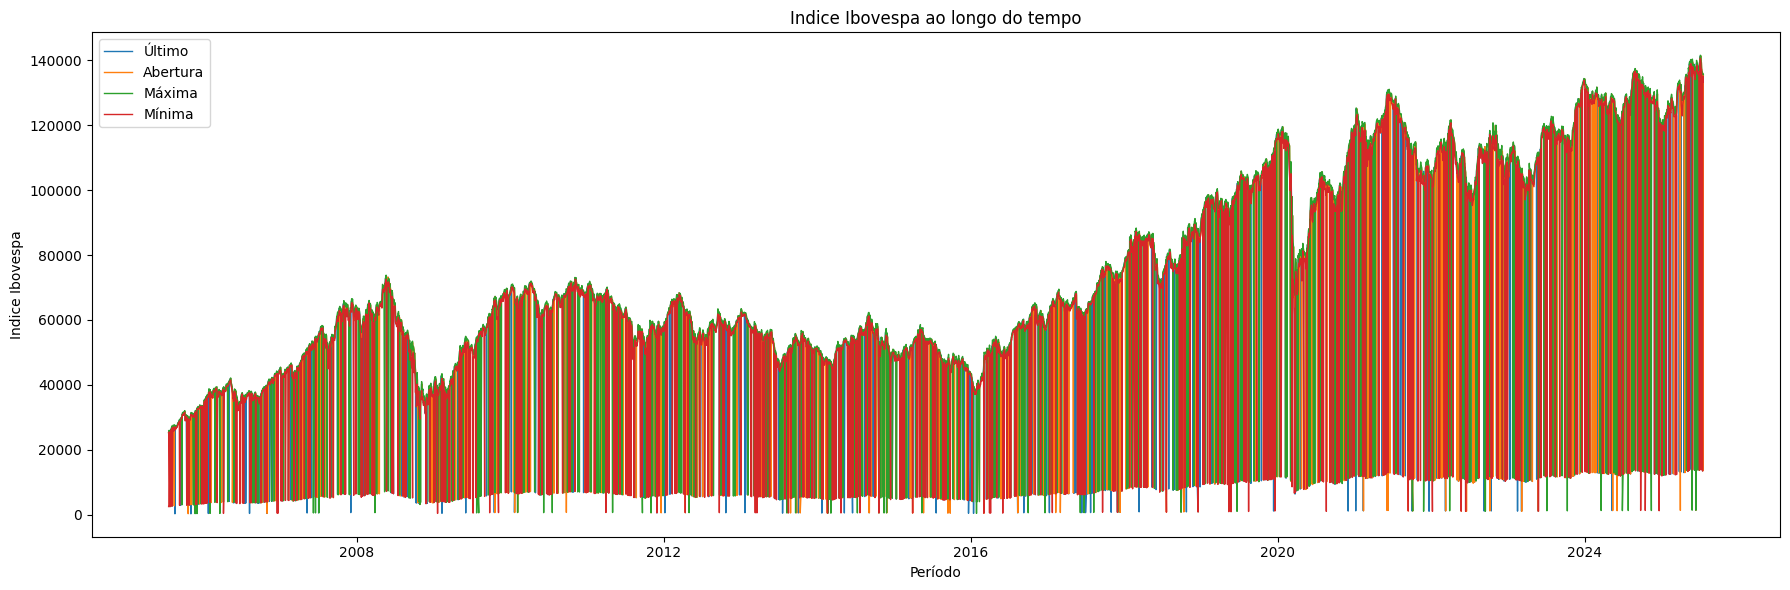

In [164]:
# Criando gráfico de indice ibovespa ao longo do tempo
plt.figure(figsize=(18,6))

for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    plt.plot(df.index, df[col], label=col, linewidth=1)

plt.xlabel('Período')
plt.ylabel('Indice Ibovespa')
plt.legend(loc='best')
plt.title('Indice Ibovespa ao longo do tempo')

Em primeira análise, é possível observar que as variáveis tem um comportamento muito parecido ao longo do tempo, seguindo os mesmos comportamentos de alta e queda.

Text(0.5, 1.0, 'Volume Ibovespa ao longo do tempo')

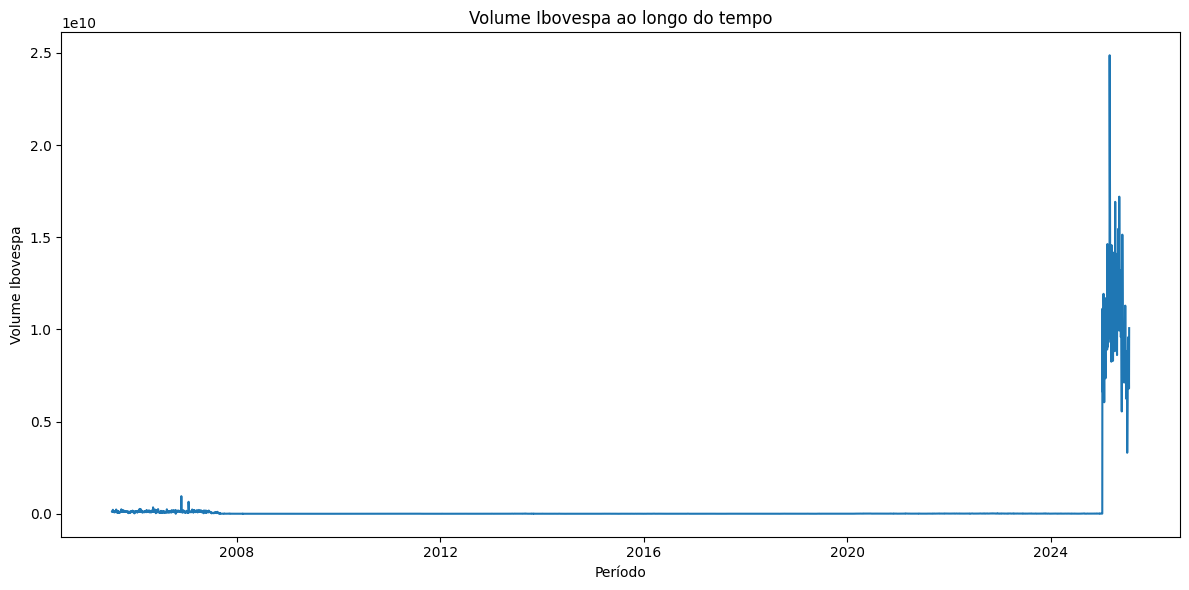

In [165]:
# Criando gráfico de Volume ibovespa ao longo do tempo
plt.figure(figsize=(12,6))

plt.plot(df['Volume'])

plt.xlabel('Período')
plt.ylabel('Volume Ibovespa')
plt.title('Volume Ibovespa ao longo do tempo')

Conseguimos observar que houve um aumento exponencial no volume negociado a partir de 2025, criando uma distorção no gráfico, porém durante esse mesmo ano o volume vem caindo de maneira consideravel.

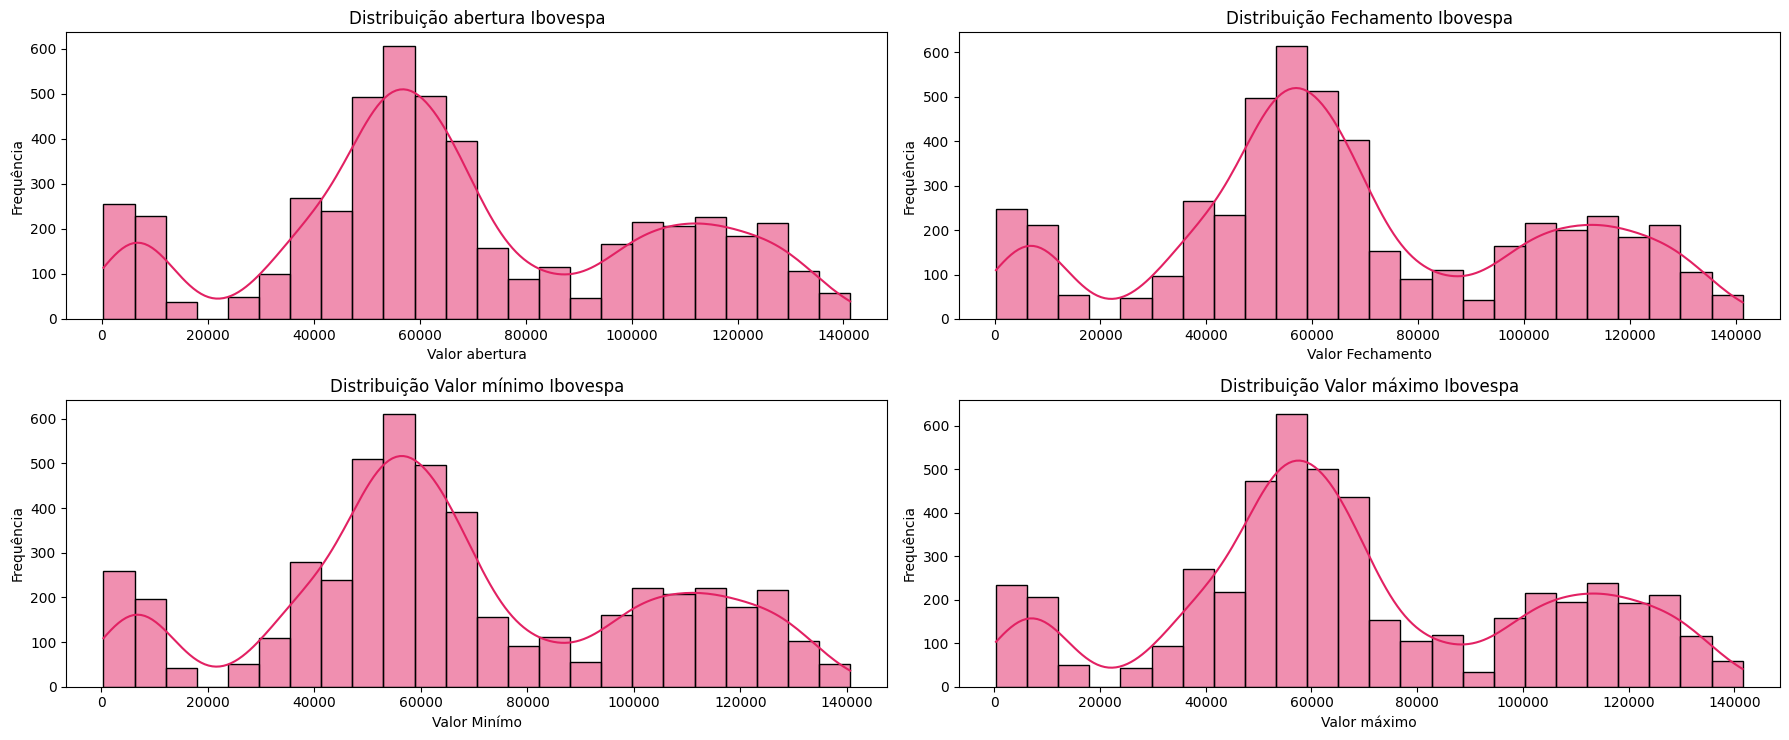

In [166]:
# Criando histograma para analisar frequências
fig, axes = plt.subplots(2, 2, figsize=(18,7.5))
axes = axes.flatten()

sns.histplot(data=df, x='Abertura', kde=True, ax=axes[0], color='#e22163')
axes[0].set_title('Distribuição abertura Ibovespa')
axes[0].set_xlabel('Valor abertura')
axes[0].set_ylabel('Frequência')

sns.histplot(data=df, x='Último', kde=True, ax=axes[1],color='#e22163')
axes[1].set_title('Distribuição Fechamento Ibovespa')
axes[1].set_xlabel('Valor Fechamento')
axes[1].set_ylabel('Frequência')


sns.histplot(data=df, x='Mínima', kde=True, ax=axes[2],color='#e22163')
axes[2].set_title('Distribuição Valor mínimo Ibovespa')
axes[2].set_xlabel('Valor Minímo')
axes[2].set_ylabel('Frequência')

sns.histplot(data=df, x='Máxima', kde=True, ax=axes[3],color='#e22163')
axes[3].set_title('Distribuição Valor máximo Ibovespa')
axes[3].set_xlabel('Valor máximo')
axes[3].set_ylabel('Frequência')

plt.tight_layout()
plt.show()

In [167]:
# Testando hipótese de normalidade de frequências para variáveis do indice Ibovespa
stat, p = shapiro(df['Último'])
print('Valores de fechamento índice Ibovespa:')
print('Estatística de teste: {:.4f}, valor p: {}'.format(stat, p))

if p > 0.05:
  print('Não há evidência suficiente para rejeitar a hipótese de normalidade')
else:
  print('A hipótese de normalidade é rejeitada')
  print('Como todos os gráficos tem distribuições semelhantes, é possivel concluir o mesmo resultado para todos.')

Valores de fechamento índice Ibovespa:
Estatística de teste: 0.9554, valor p: 1.8963176910364424e-36
A hipótese de normalidade é rejeitada
Como todos os gráficos tem distribuições semelhantes, é possivel concluir o mesmo resultado para todos.


 Ao comparar a curva normal das variáveis, é possivel constatar uma assimetria entre as distribuições, o que é confirmado através da estatística de teste, algo que pode prejudicar modelos preditivos que se desempenham melhor com normalidades.

In [168]:
# Testando hipótese de comparação estátiscas entre as variáveis
stat, p = mannwhitneyu(
    df['Abertura'].sample(len(df['Abertura']), random_state=7),
    df['Último'].sample(len(df['Último']), random_state=7),
    alternative='less')

print('Analise estátistica entre Valor de abertura e valor de fechamento do índice Ibovespa:')
print('Estatística de teste U: ', stat)
print('Valor p: {}'.format(p))

alpha = 0.05

if p < alpha:
  print('Diferença estatiscamente significante')
else:
  print('Não há diferença estatiscamente significante')

Analise estátistica entre Valor de abertura e valor de fechamento do índice Ibovespa:
Estatística de teste U:  12258400.5
Valor p: 0.4784157320025786
Não há diferença estatiscamente significante


In [169]:
# Testando hipótese de comparação estátiscas entre as variáveis
stat, p = mannwhitneyu(
    df['Mínima'].sample(len(df['Mínima']), random_state=7),
    df['Máxima'].sample(len(df['Máxima']), random_state=7),
    alternative='less')

print('Analise estátistica entre Valor de Mínima e valor de máxima do índice Ibovespa:')
print('Estatística de teste U: ', stat)
print('Valor p: {}'.format(p))

alpha = 0.05

if p < alpha:
  print('Diferença estatiscamente significante')
else:
  print('Não há diferença estatiscamente significante')

Analise estátistica entre Valor de Mínima e valor de máxima do índice Ibovespa:
Estatística de teste U:  11940895.5
Valor p: 0.01115226523513597
Diferença estatiscamente significante


Através do teste de *mannwhitneyu* conseguimos comprovar que não há diferença estátisca significante entre o valor de abertura e fechamento, diferente do teste entre a mínima e máxima que comprovaram ter diferenças, podendo ser features úteis para o modelo.

In [170]:
# Reduzindo as frequências de volume para gráfico de histograma
df['Vol. Sqrt'] = np.sqrt(df['Volume'])

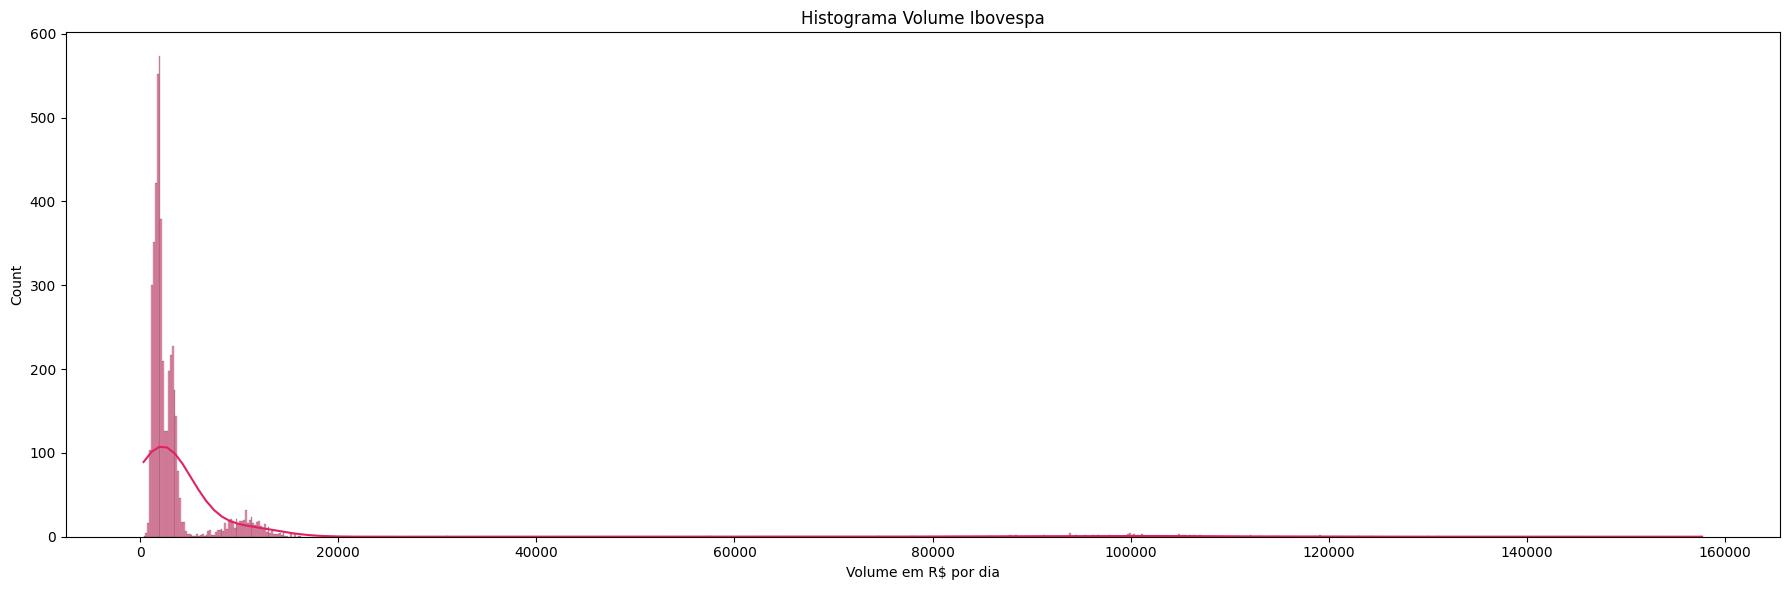

In [171]:
# Criando histograma para entender a distribuição do volume

plt.figure(figsize=(18, 6))

sns.histplot(data=df, x='Vol. Sqrt', kde=True,color='#e22163')
plt.xlabel('Volume em R$ por dia')
plt.title('Histograma Volume Ibovespa')

plt.show()

In [172]:
# Testando hipótese de normalidade de frequências para volume do indice Ibovespa
stat, p = shapiro(df['Volume'])
print('Volume índice Ibovespa:')
print('Estatística de teste: {:.4f}, valor p: {}'.format(stat, p))

if p > 0.05:
  print('Não há evidência suficiente para rejeitar a hipótese de normalidade')
else:
  print('A hipótese de normalidade é rejeitada')

Volume índice Ibovespa:
Estatística de teste: 0.1579, valor p: 1.4066962095433474e-91
A hipótese de normalidade é rejeitada


Através do histograma elevado ao ², fica claro que a distribuição da variável de volume é assimétrica, oque também é comprovado pela estatística de teste, além disso é possível identificar com mais clareza uma grande distorção das frequências (outliers).

In [173]:
#Analisando a relação de cada variável x variável alvo
# Formatando o tamanho do plot
plt.rcParams["figure.figsize"] = [8.00, 4.00]
plt.rcParams["figure.autolayout"] = True

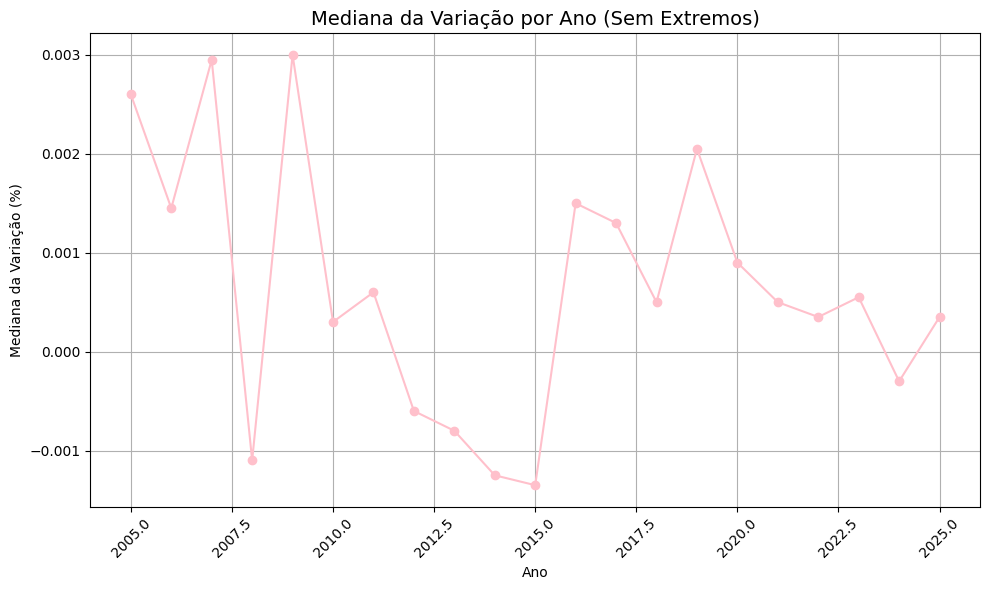

In [174]:
plt.figure(figsize=(10, 6))
plt.plot(median_sem_extremos.index, median_sem_extremos['Var%'].values, marker='o', color='pink')
plt.title('Mediana da Variação por Ano (Sem Extremos)', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Mediana da Variação (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

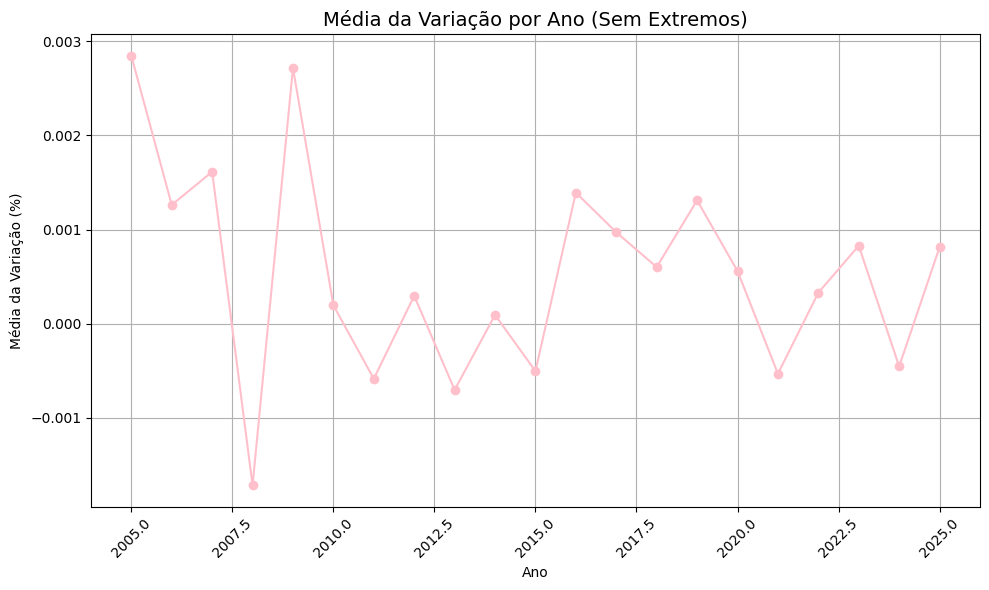

In [175]:
# Tendência da variação média ao longo dos anos
plt.figure(figsize=(10, 6))
plt.plot(mean_sem_extremos.index, mean_sem_extremos['Var%'].values, marker='o', color='pink')
plt.title('Média da Variação por Ano (Sem Extremos)', fontsize=14)
plt.xlabel('Ano')
plt.ylabel('Média da Variação (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Ao comparar a media e mediana da variação, entendemos que o comportamento da variável tem oscilações ao longo dos anos.

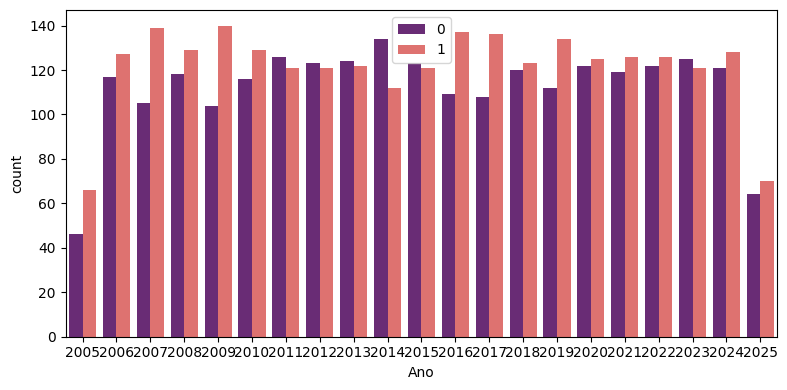

In [176]:
# Visualizando a variável ano x subida

sns.countplot(data = df_sem_extremos, x = "Ano", hue = "Previsão", palette='magma')
plt.legend(loc='best')
plt.show()

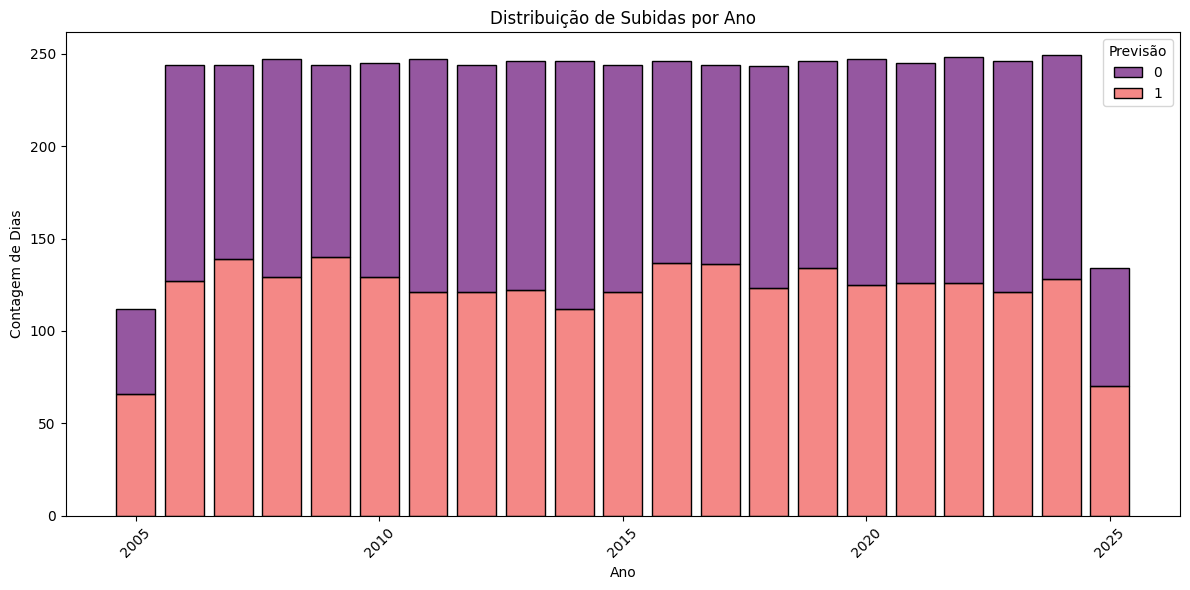

In [177]:
#analisando a distribuição de dados
#Subidas significativas

plt.figure(figsize=(12, 6))
sns.histplot(data=df_sem_extremos, x='Ano', hue='Previsão', multiple='stack', shrink=0.8, discrete=True, palette='magma')
plt.title("Distribuição de Subidas por Ano")
plt.xlabel("Ano")
plt.ylabel("Contagem de Dias")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Axes: xlabel='Previsão', ylabel='count'>

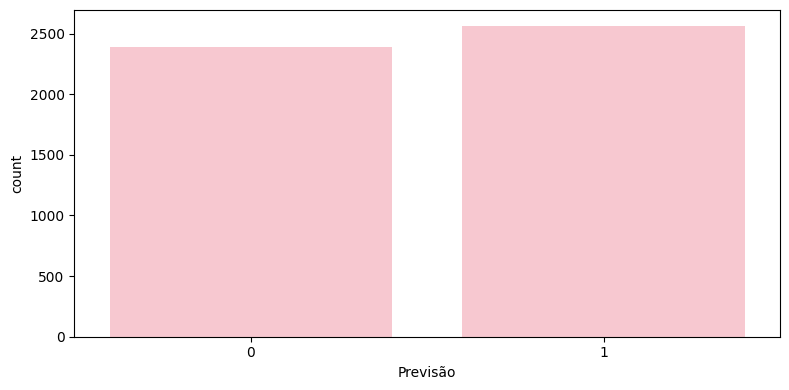

In [178]:
# Verificando balanceamento da classe dos dados
sns.countplot(x='Previsão', data=df, color='pink')

É possivel identificar uma boa distribuição da nossa variável target, oque é excelente para o treinamento do nosso modelo.

Text(0.5, 1.0, 'Variação Indice Ibovespa ao longo do tempo')

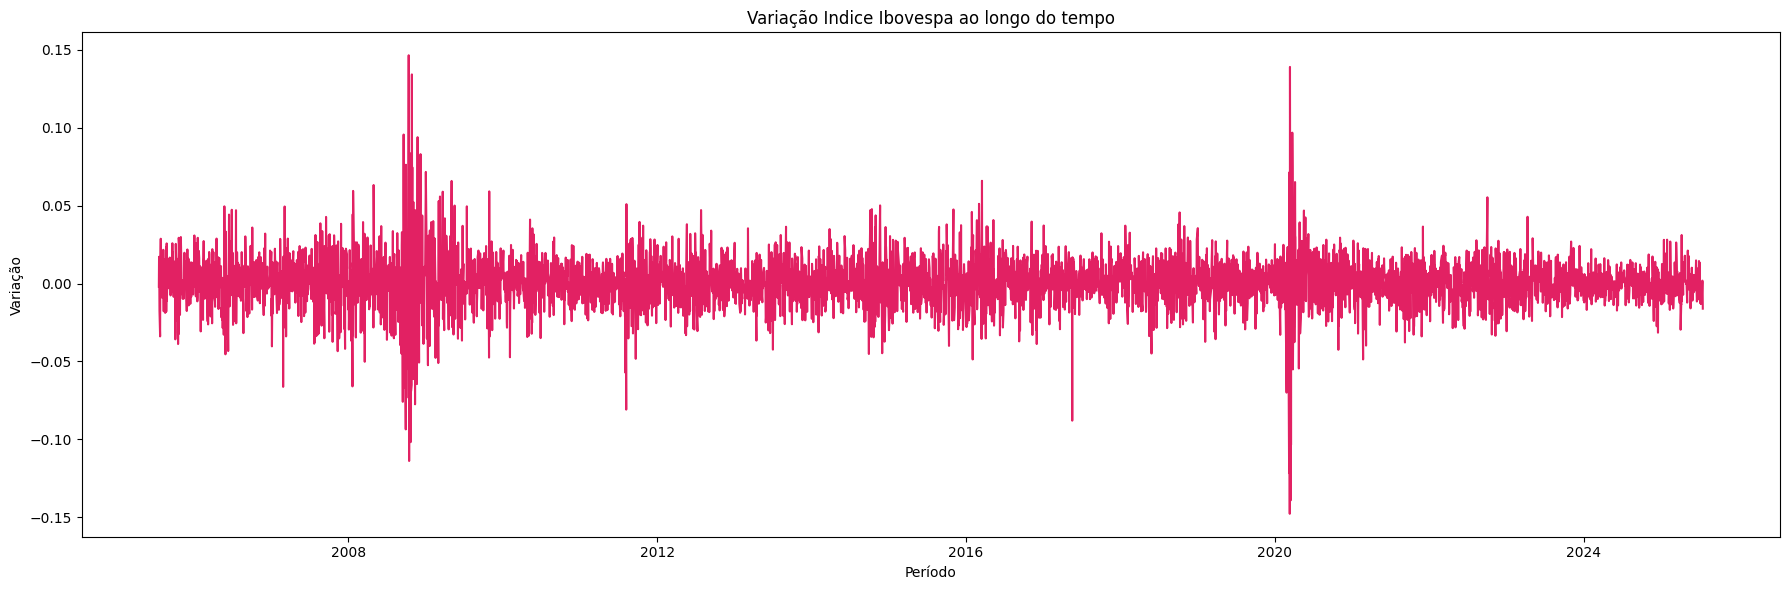

In [179]:
# Criando gráfico de variação do indice ibovespa ao longo do tempo
plt.figure(figsize=(18,6))

plt.plot(df['Var%'], color='#e22163')

plt.xlabel('Período')
plt.ylabel('Variação')
plt.title('Variação Indice Ibovespa ao longo do tempo')

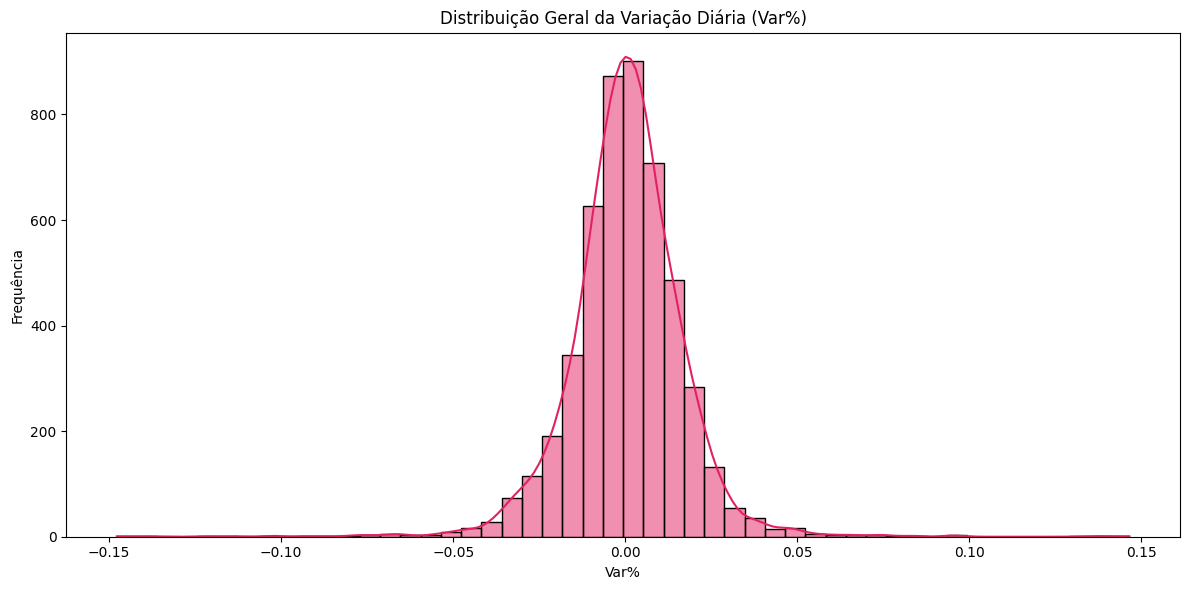

In [180]:
# Histograma com curva de densidade (distribuição da variação diária)
plt.figure(figsize=(12, 6))
sns.histplot(df['Var%'], bins=50, kde=True, color='#e22163')
plt.title('Distribuição Geral da Variação Diária (Var%)')
plt.xlabel('Var%')
plt.ylabel('Frequência')
plt.grid(False)
plt.show()

A variação diária, é a unica variável tem uma distribuição normalizada, tendo a maioria das frequências concentradas entre -5% e 5%.

/tmp/ipython-input-3956738166.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = df_sem_extremos, x='Mes', y='Var%', palette='magma')


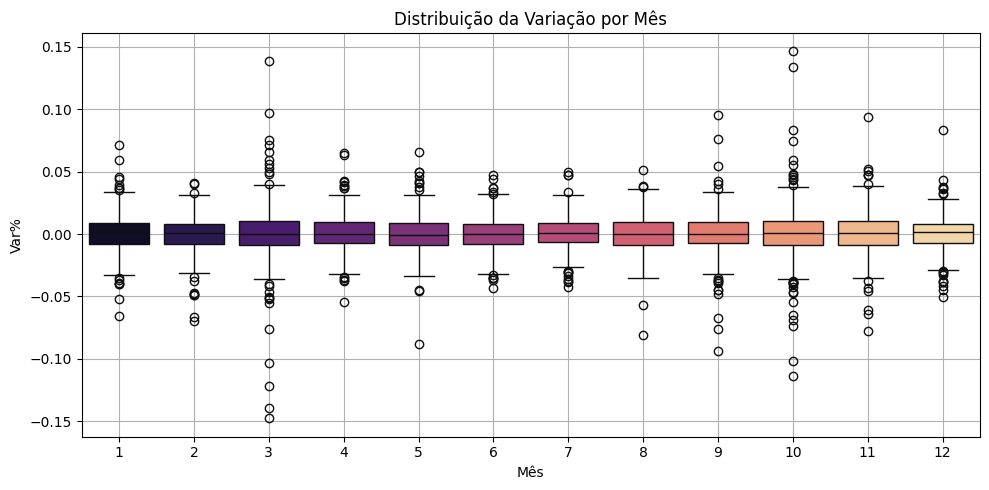

In [181]:
# Adiciona coluna com o mês da data
df_sem_extremos['Mes'] = df_sem_extremos['MesAno'].dt.month
# Boxplot da variação por mês
plt.figure(figsize=(10, 5))
sns.boxplot(data = df_sem_extremos, x='Mes', y='Var%', palette='magma')
plt.title('Distribuição da Variação por Mês')
plt.xlabel('Mês')
plt.ylabel('Var%')
plt.grid(True)
plt.show()

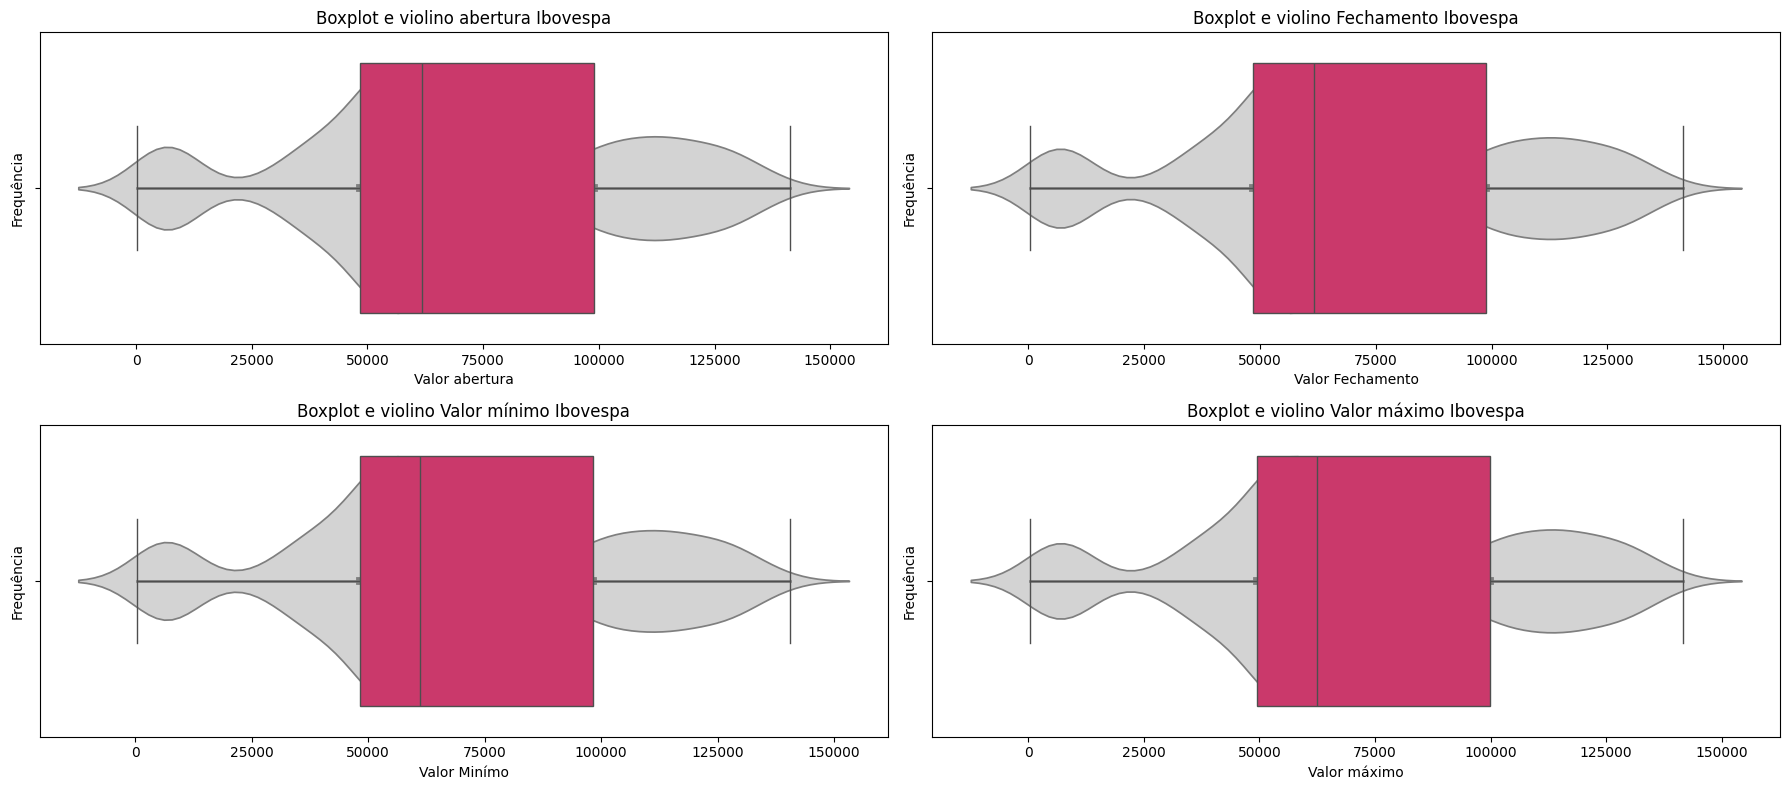

In [182]:
# Criando gráficos de violino e boxplot para analisar outliers
fig, axes = plt.subplots(2, 2, figsize=(18,8))
axes = axes.flatten()

sns.violinplot(x='Abertura', data=df, ax=axes[0], color='lightgray')
sns.boxplot(x='Abertura', data=df, ax=axes[0], whis=1.5, color='#e22163')
axes[0].set_title('Boxplot e violino abertura Ibovespa')
axes[0].set_xlabel('Valor abertura')
axes[0].set_ylabel('Frequência')

sns.violinplot(x='Último', data=df, ax=axes[1], color='lightgray')
sns.boxplot(x='Último', data=df, ax=axes[1], whis=1.5, color='#e22163')
axes[1].set_title('Boxplot e violino Fechamento Ibovespa')
axes[1].set_xlabel('Valor Fechamento')
axes[1].set_ylabel('Frequência')

sns.violinplot(x='Mínima', data=df, ax=axes[2], color='lightgray')
sns.boxplot(x='Mínima', data=df, ax=axes[2], whis=1.5, color='#e22163')
axes[2].set_title('Boxplot e violino Valor mínimo Ibovespa')
axes[2].set_xlabel('Valor Minímo')
axes[2].set_ylabel('Frequência')

sns.violinplot(x='Máxima', data=df, ax=axes[3], color='lightgray')
sns.boxplot(x='Máxima', data=df, ax=axes[3], whis=1.5, color='#e22163')
axes[3].set_title('Boxplot e violino Valor máximo Ibovespa')
axes[3].set_xlabel('Valor máximo')
axes[3].set_ylabel('Frequência')


plt.tight_layout()
plt.show()

In [183]:
# Criando variável de fechamento em alta
df['Fechamento_Amanhã'] = df['Último'].shift(-1)
df['Class'] = (df['Fechamento_Amanhã'] > df['Último']).astype(int)

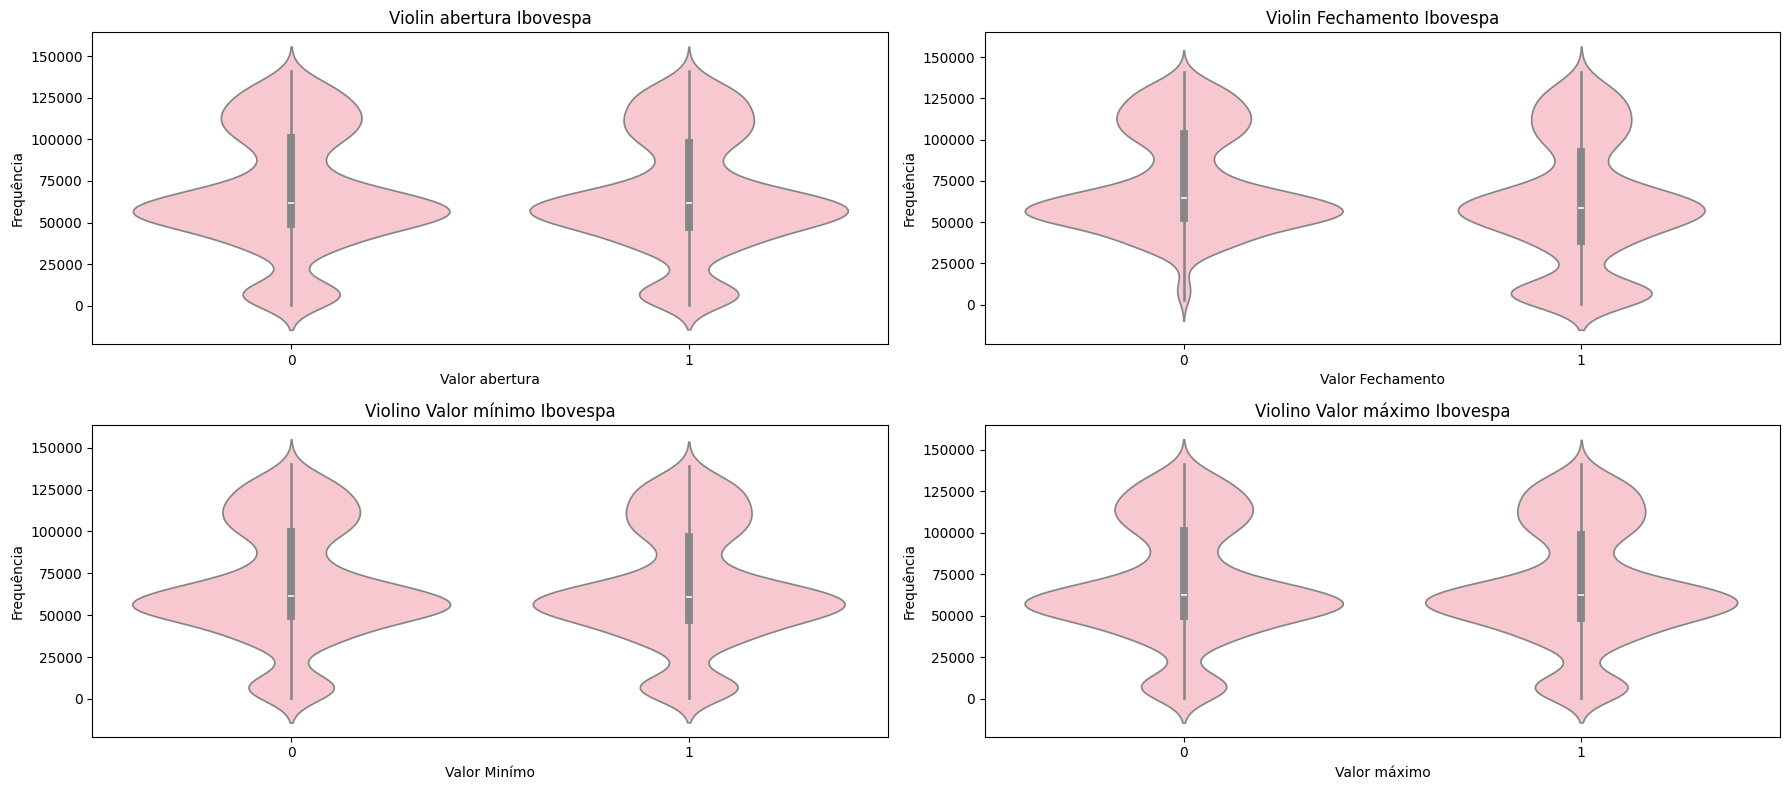

In [184]:
# Criando gráficos de violino para entender comportamento das variáveis quando o indice fecha em alta ou em baixa
fig, axes = plt.subplots(2, 2, figsize=(18,8))
axes = axes.flatten()

sns.violinplot(x='Previsão', y='Abertura', data=df, ax=axes[0], color='pink')
axes[0].set_title('Violin abertura Ibovespa')
axes[0].set_xlabel('Valor abertura')
axes[0].set_ylabel('Frequência')

sns.violinplot(x='Previsão', y='Último', data=df, ax=axes[1], color='pink')
axes[1].set_title('Violin Fechamento Ibovespa')
axes[1].set_xlabel('Valor Fechamento')
axes[1].set_ylabel('Frequência')

sns.violinplot(x='Previsão', y='Mínima', data=df, ax=axes[2], color='pink')
axes[2].set_title('Violino Valor mínimo Ibovespa')
axes[2].set_xlabel('Valor Minímo')
axes[2].set_ylabel('Frequência')

sns.violinplot(x='Previsão', y='Máxima', data=df, ax=axes[3], color='pink')
axes[3].set_title('Violino Valor máximo Ibovespa')
axes[3].set_xlabel('Valor máximo')
axes[3].set_ylabel('Frequência')


plt.tight_layout()
plt.show()

Reforçando o comportamento parecido das variáveis de valores através dos gráficos de boxplot e violin.

In [185]:
# Criando matriz de correlação
correlation_matrix = df[['Último', 'Abertura','Máxima','Mínima','Var%','Volume']].corr(numeric_only=True)

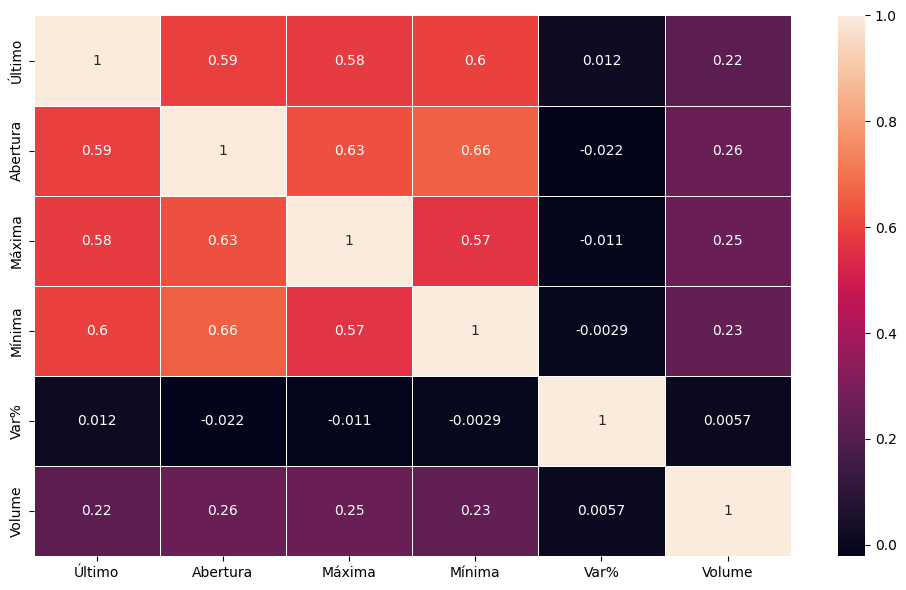

In [186]:
fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(data=correlation_matrix, annot=True, linewidths=.5, ax=ax)

plt.show()

É possível identificar que as variáveis tem correlações muito parecidas, oque pode dificultar no treinamento do nosso modelo.

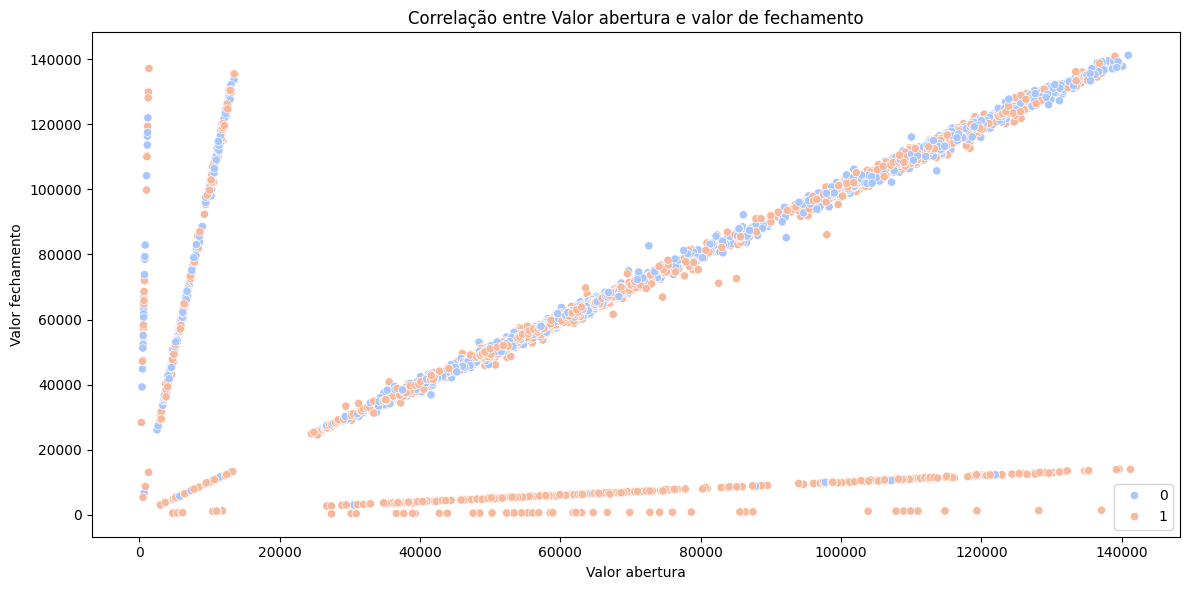

In [187]:
# Criando gráfico de dispersão entre Valor de Abertura e fechamento índice Ibovespa
plt.figure(figsize=(12,6))
sns.scatterplot(x='Abertura', y='Último', hue='Previsão', data=df, palette='coolwarm')
plt.xlabel('Valor abertura')
plt.ylabel('Valor fechamento')
plt.title('Correlação entre Valor abertura e valor de fechamento')
plt.legend(loc='best')

plt.show()

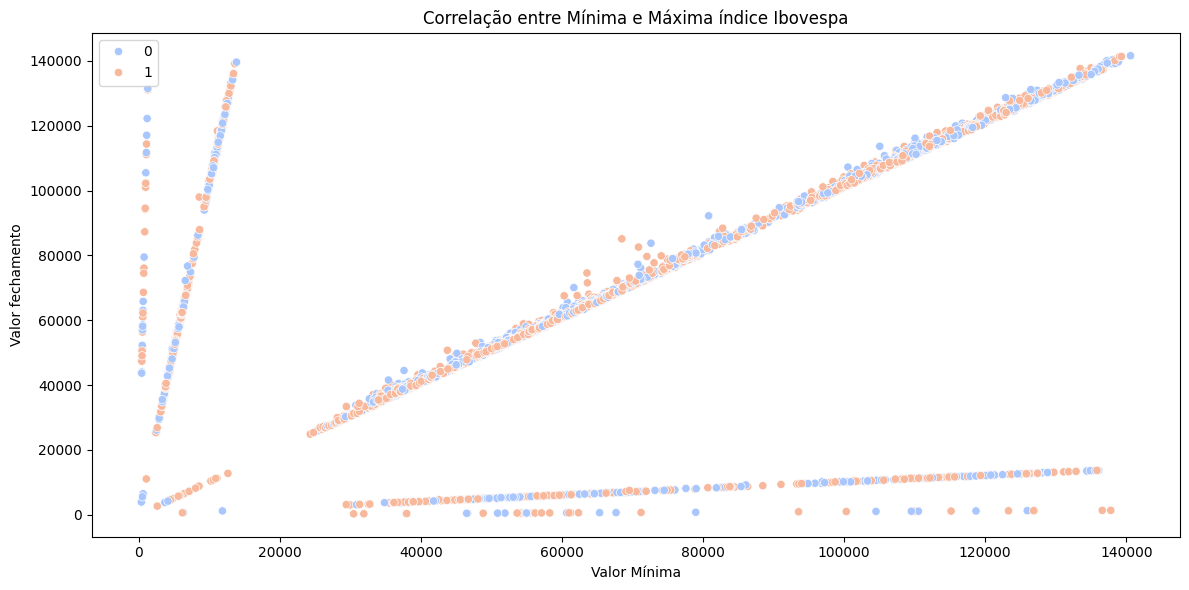

In [188]:
# Criando gráfico de dispersão entre Mínima e Máxima do índice Ibovespa
plt.figure(figsize=(12,6))
sns.scatterplot(x='Mínima', y='Máxima', hue='Previsão', data=df, palette='coolwarm')
plt.xlabel('Valor Mínima')
plt.ylabel('Valor fechamento')
plt.title('Correlação entre Mínima e Máxima índice Ibovespa')
plt.legend(loc='best')

plt.show()

Apesar de existirem comportamentos distintos, é possivel observar que a maioria dos valores de fato andam juntos.

# FEATURE ENGINING

In [189]:
# Features

# 1. Variação do dia: Utilizando "Último" - "Abertura"
df['Variação_Dia'] = df['Último'] - df['Abertura']
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,MesAno,Ano,Volume,Fechamento_Amanhã,Previsão,Vol. Sqrt,Class,Variação_Dia
Data,,,,,,,,,,,,,,
2005-07-19,25271.0,25312.0,25312.0,2496.0,"119,27M",-0.0020,2005-07-01,2005,119270000.0,25705.0,1,10921.080533,1,-41.0
2005-07-20,25705.0,25268.0,25795.0,2497.0,"130,63M",0.0172,2005-07-01,2005,130630000.0,25842.0,1,11429.348188,1,437.0
2005-07-21,25842.0,25706.0,25964.0,25505.0,"109,50M",0.0053,2005-07-01,2005,109500000.0,25391.0,0,10464.224768,0,136.0
2005-07-22,25391.0,25834.0,25848.0,25244.0,"166,89M",-0.0175,2005-07-01,2005,166890000.0,24531.0,0,12918.591254,0,-443.0
2005-07-25,24531.0,25388.0,25388.0,2441.0,"218,22M",-0.0339,2005-07-01,2005,218220000.0,24868.0,1,14772.271322,1,-857.0


In [190]:
# 2. Lag 1: Fechamento do dia anterior
df['Fechamento_Anterior'] = df['Último'].shift(1)
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,MesAno,Ano,Volume,Fechamento_Amanhã,Previsão,Vol. Sqrt,Class,Variação_Dia,Fechamento_Anterior
Data,,,,,,,,,,,,,,,
2005-07-19,25271.0,25312.0,25312.0,2496.0,"119,27M",-0.0020,2005-07-01,2005,119270000.0,25705.0,1,10921.080533,1,-41.0,NaN
2005-07-20,25705.0,25268.0,25795.0,2497.0,"130,63M",0.0172,2005-07-01,2005,130630000.0,25842.0,1,11429.348188,1,437.0,25271.0
2005-07-21,25842.0,25706.0,25964.0,25505.0,"109,50M",0.0053,2005-07-01,2005,109500000.0,25391.0,0,10464.224768,0,136.0,25705.0
2005-07-22,25391.0,25834.0,25848.0,25244.0,"166,89M",-0.0175,2005-07-01,2005,166890000.0,24531.0,0,12918.591254,0,-443.0,25842.0
2005-07-25,24531.0,25388.0,25388.0,2441.0,"218,22M",-0.0339,2005-07-01,2005,218220000.0,24868.0,1,14772.271322,1,-857.0,25391.0


In [191]:
# 3. Média Móvel de 5 Dias
df['Média_5_Dias'] = df['Último'].rolling(5).mean()
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,MesAno,Ano,Volume,Fechamento_Amanhã,Previsão,Vol. Sqrt,Class,Variação_Dia,Fechamento_Anterior,Média_5_Dias
Data,,,,,,,,,,,,,,,,
2005-07-19,25271.0,25312.0,25312.0,2496.0,"119,27M",-0.0020,2005-07-01,2005,119270000.0,25705.0,1,10921.080533,1,-41.0,NaN,NaN
2005-07-20,25705.0,25268.0,25795.0,2497.0,"130,63M",0.0172,2005-07-01,2005,130630000.0,25842.0,1,11429.348188,1,437.0,25271.0,NaN
2005-07-21,25842.0,25706.0,25964.0,25505.0,"109,50M",0.0053,2005-07-01,2005,109500000.0,25391.0,0,10464.224768,0,136.0,25705.0,NaN
2005-07-22,25391.0,25834.0,25848.0,25244.0,"166,89M",-0.0175,2005-07-01,2005,166890000.0,24531.0,0,12918.591254,0,-443.0,25842.0,NaN
2005-07-25,24531.0,25388.0,25388.0,2441.0,"218,22M",-0.0339,2005-07-01,2005,218220000.0,24868.0,1,14772.271322,1,-857.0,25391.0,25348.0


In [192]:
df['Retorno_Pct'] = df['Último'].pct_change().shift(-1)
df['Previsão'] = (df['Retorno_Pct'] > 0.005).astype(int)

In [193]:
# Remover os NaN
df = df.dropna()
df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,MesAno,Ano,Volume,Fechamento_Amanhã,Previsão,Vol. Sqrt,Class,Variação_Dia,Fechamento_Anterior,Média_5_Dias,Retorno_Pct
Data,,,,,,,,,,,,,,,,,
2005-07-25,24531.0,25388.0,25388.0,2441.0,"218,22M",-0.0339,2005-07-01,2005,218220000.0,24868.0,1,14772.271322,1,-857.0,25391.0,25348.0,0.013738
2005-07-26,24868.0,24506.0,24899.0,24328.0,"158,98M",0.0137,2005-07-01,2005,158980000.0,25338.0,1,12608.727136,1,362.0,24531.0,25267.4,0.018900
2005-07-27,25338.0,24882.0,25362.0,24774.0,"150,58M",0.0189,2005-07-01,2005,150580000.0,26068.0,1,12271.104270,1,456.0,24868.0,25194.0,0.028810
2005-07-28,26068.0,2534.0,26125.0,2534.0,"144,82M",0.0288,2005-07-01,2005,144820000.0,26042.0,0,12034.118165,0,23534.0,25338.0,25239.2,-0.000997
2005-07-29,26042.0,26065.0,26306.0,25946.0,"115,05M",-0.0010,2005-07-01,2005,115050000.0,26298.0,1,10726.136303,1,-23.0,26068.0,25369.4,0.009830


In [194]:
# Jogar colunas "Fechamento_Amanhã" e "Previsão" para o final da df
df = df[['Último', 'Abertura', 'Variação_Dia', 'Fechamento_Anterior', 'Média_5_Dias', 'Retorno_Pct', 'Fechamento_Amanhã', 'Previsão']]
df.head()

,Último,Abertura,Variação_Dia,Fechamento_Anterior,Média_5_Dias,Retorno_Pct,Fechamento_Amanhã,Previsão
Data,,,,,,,,
2005-07-25,24531.0,25388.0,-857.0,25391.0,25348.0,0.013738,24868.0,1
2005-07-26,24868.0,24506.0,362.0,24531.0,25267.4,0.018900,25338.0,1
2005-07-27,25338.0,24882.0,456.0,24868.0,25194.0,0.028810,26068.0,1
2005-07-28,26068.0,2534.0,23534.0,25338.0,25239.2,-0.000997,26042.0,0
2005-07-29,26042.0,26065.0,-23.0,26068.0,25369.4,0.009830,26298.0,1


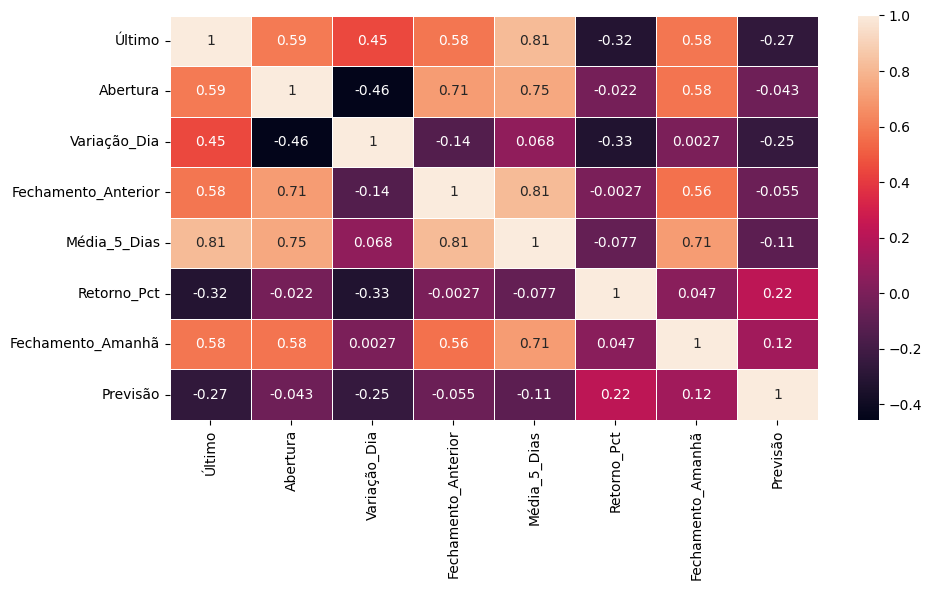

In [195]:
fig, ax = plt.subplots(figsize=(10,6))

sns.heatmap(data=df.corr(), annot=True, linewidths=.5, ax=ax)

plt.show()

# MODELOS DE CLASSIFICAÇÃO

## RANDOM FOREST CLASSIFIER

In [196]:
x = df[['Variação_Dia', 'Fechamento_Anterior', 'Média_5_Dias']]
y = df['Previsão']

In [197]:
# Treino: todos os dias, menos os 30 últimos
x_treino = x[:-30]
y_treino = y[:-30]

In [198]:
# Teste: último dia
x_teste = x[-30:]
y_teste = y[-30:]

In [199]:
# Treinando modelo Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

modelo = RandomForestClassifier(class_weight='balanced', random_state=30)
modelo.fit(x_treino, y_treino)

previsoes = modelo.predict(x_teste)

In [200]:
# Acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"Acurácia: {acuracia:.2%}")

Acurácia: 83.33%


### VALIDANDO MODELO

In [201]:
# Métricas de validação
probs_modelo = modelo.predict_proba(x_teste)[:, 1]
accuracy_modelo = accuracy_score(y_teste, previsoes)
reports_modelo = classification_report(y_teste, previsoes)
matriz_modelo = confusion_matrix(y_teste, previsoes)
fpr_modelo, tpr_modelo, _ = roc_curve(y_teste, probs_modelo)
roc_auc = auc(fpr_modelo, tpr_modelo)
importances_modelo = modelo.feature_importances_

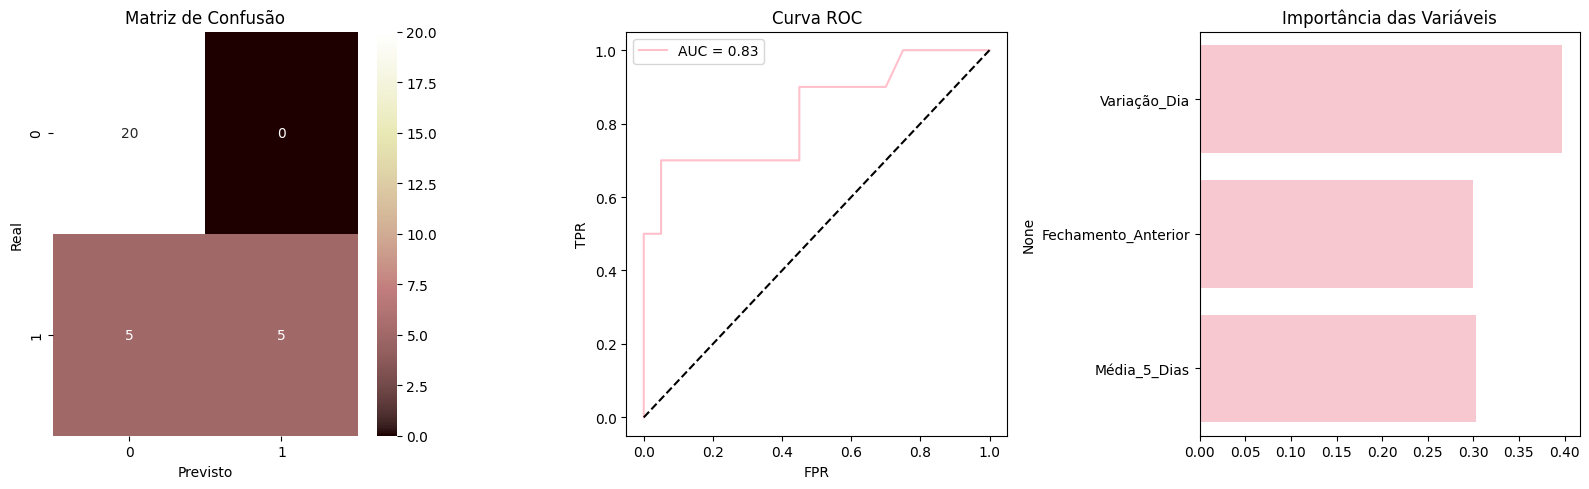

In [202]:
# Gráficos de validação do modelo
plt.figure(figsize=(16, 5))

# Matriz de confusão
plt.subplot(1, 3, 1)
sns.heatmap(matriz_modelo, annot=True, fmt='d', cmap='pink')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')

# Curva ROC
plt.subplot(1, 3, 2)
plt.plot(fpr_modelo, tpr_modelo, label=f'AUC = {roc_auc:.2f}', color='pink')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# Importância das variáveis
plt.subplot(1, 3, 3)
sns.barplot(x=importances_modelo, y=x.columns, color='pink')
plt.title('Importância das Variáveis')

plt.tight_layout()
plt.show()

In [203]:
print(reports_modelo)

              precision    recall  f1-score   support

           0       0.80      1.00      0.89        20
           1       1.00      0.50      0.67        10

    accuracy                           0.83        30
   macro avg       0.90      0.75      0.78        30
weighted avg       0.87      0.83      0.81        30



## NAIVE BAYES

In [204]:
# Treino: todos os dias, menos os 30 últimos
x_treino = x[:-30]
y_treino = y[:-30]

# Teste: último dia
x_teste = x[-30:]
y_teste = y[-30:]

In [205]:
# Instanciando e treinando modelo
gnb = GaussianNB()
gnb.fit(x_treino, y_treino)

GaussianNB()

In [206]:
# Rodando modelo
y_pred_gnb = gnb.predict(x_teste)

In [207]:
# Validando modelo
accuracy_gnb = accuracy_score(y_teste, y_pred_gnb)

print('Acurracy: {:.2f}'.format(round(accuracy_gnb, 2)))

Acurracy: 0.80


### VALIDANDO MODELO

In [208]:
# Métricas de validação
probs_gnb = gnb.predict_proba(x_teste)[:, 1]
accuracy_gnb = accuracy_score(y_teste, y_pred_gnb)
reports_gnb = classification_report(y_teste, y_pred_gnb)
matriz_gnb = confusion_matrix(y_teste, y_pred_gnb)
fpr_gnb, tpr_gnb, _ = roc_curve(y_teste, probs_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
result_gnb = permutation_importance(gnb, x_teste, y_teste, n_repeats=30, random_state=42, n_jobs=-1)
importances_gnb = result_gnb.importances_mean

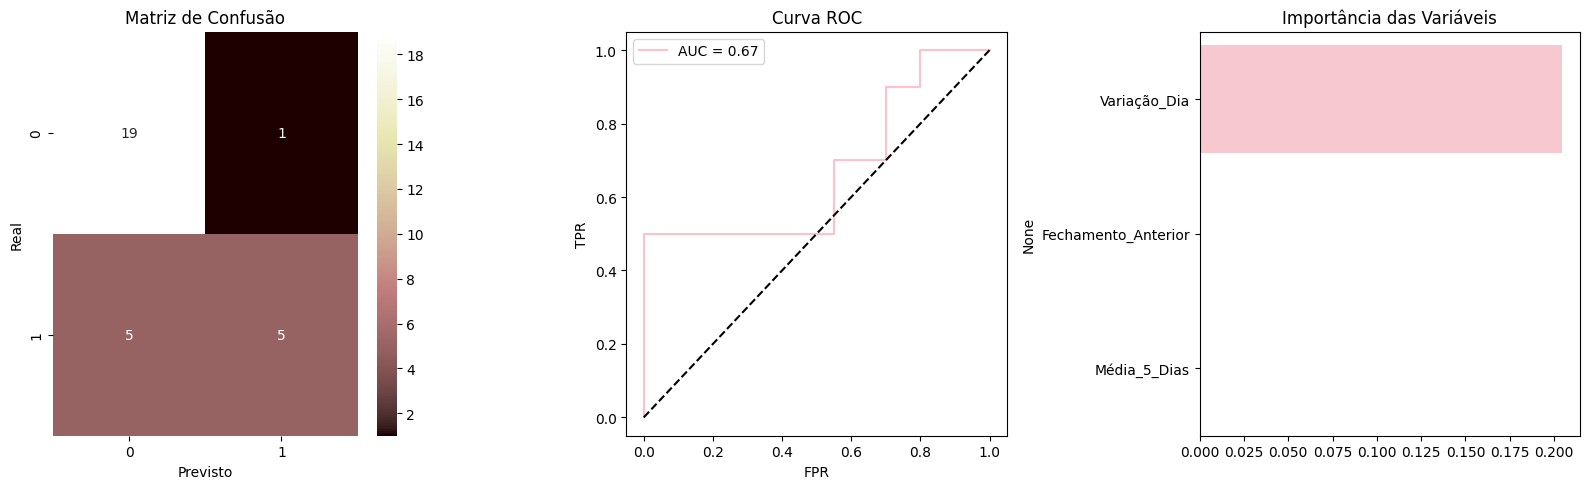

In [209]:
# Gráficos de validação do modelo
plt.figure(figsize=(16, 5))

# Matriz de confusão
plt.subplot(1, 3, 1)
sns.heatmap(matriz_gnb, annot=True, fmt='d', cmap='pink')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')

# Curva ROC
plt.subplot(1, 3, 2)
plt.plot(fpr_gnb, tpr_gnb, label=f'AUC = {roc_auc_gnb:.2f}', color='pink')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# Importância das variáveis
plt.subplot(1, 3, 3)
sns.barplot(x=importances_gnb, y=x.columns, color='pink')
plt.title('Importância das Variáveis')

plt.tight_layout()
plt.show()

In [210]:
print(reports_gnb)

              precision    recall  f1-score   support

           0       0.79      0.95      0.86        20
           1       0.83      0.50      0.62        10

    accuracy                           0.80        30
   macro avg       0.81      0.72      0.74        30
weighted avg       0.81      0.80      0.78        30



## KNEIGHBORS

In [211]:
# Treino: todos os dias, menos os 30 últimos
x_treino = x[:-30]
y_treino = y[:-30]

# Teste: último dia
x_teste = x[-30:]
y_teste = y[-30:]

In [212]:
# Instanciando e treinando modelo
knn = KNeighborsClassifier(n_neighbors=10, metric='euclidean', weights='distance')
knn.fit(x_treino, y_treino)

KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='distance')

In [213]:
# Rodando modelo
y_pred_knn = knn.predict(x_teste)

In [214]:
# Validando modelo
accuracy_knn = accuracy_score(y_teste, y_pred_knn)

print('Acurracy: {:.2f}'.format(round(accuracy_knn, 2)))

Acurracy: 0.80


### VALIDANDO MODELO

In [215]:
# Métricas de validação
probs_knn = knn.predict_proba(x_teste)[:, 1]
accuracy_knn = accuracy_score(y_teste, y_pred_knn)
reports_knn = classification_report(y_teste, y_pred_knn)
matriz_knn = confusion_matrix(y_teste, y_pred_knn)
fpr_knn, tpr_knn, _ = roc_curve(y_teste, probs_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
result_knn = permutation_importance(knn, x_teste, y_teste, n_repeats=30, random_state=42, n_jobs=-1)
importances_knn = result_knn.importances_mean

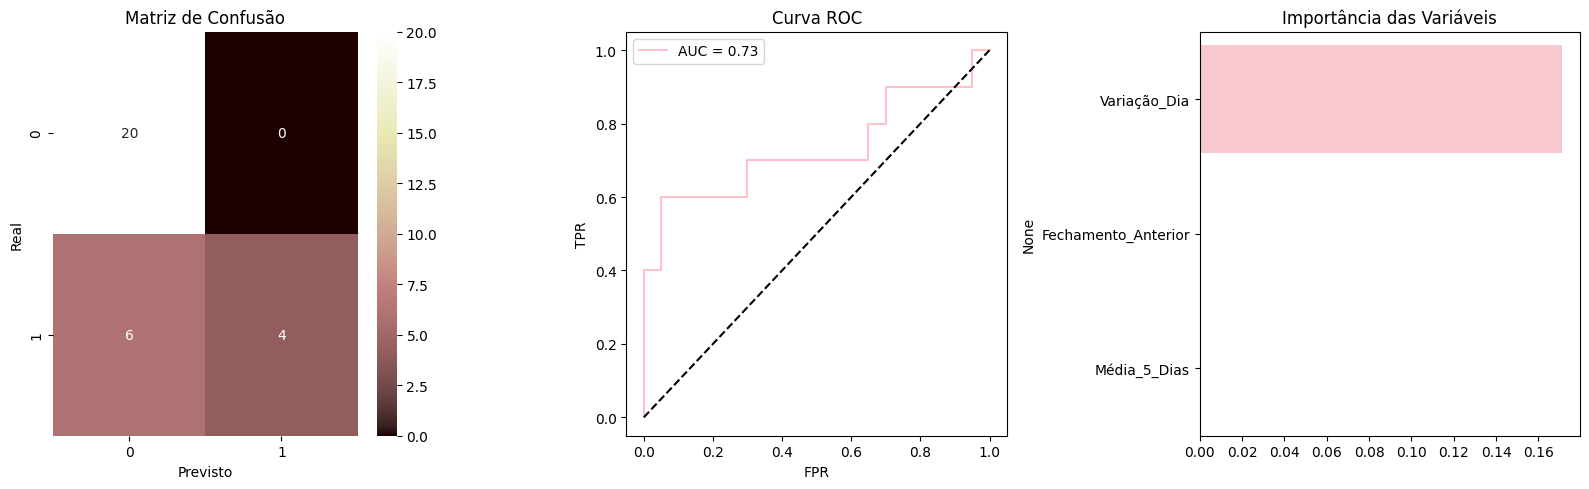

In [216]:
# Gráficos de validação do modelo
plt.figure(figsize=(16, 5))

# Matriz de confusão
plt.subplot(1, 3, 1)
sns.heatmap(matriz_knn, annot=True, fmt='d', cmap='pink')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')

# Curva ROC
plt.subplot(1, 3, 2)
plt.plot(fpr_knn, tpr_knn, label=f'AUC = {roc_auc_knn:.2f}', color='pink')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# Importância das variáveis
plt.subplot(1, 3, 3)
sns.barplot(x=importances_knn, y=x.columns, color='pink')
plt.title('Importância das Variáveis')

plt.tight_layout()
plt.show()

In [217]:
print(reports_knn)

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        20
           1       1.00      0.40      0.57        10

    accuracy                           0.80        30
   macro avg       0.88      0.70      0.72        30
weighted avg       0.85      0.80      0.77        30



# ESCOLHENDO MELHOR MODELO

In [218]:
dict_models = {
    'GNB':accuracy_gnb,
    'KNN':accuracy_knn,
    'RF':acuracia
}

In [219]:
# Selecionando melhor modelo
MelhorModelo = max(dict_models, key=dict_models.get)

print('GNB: {0:.2f}\nKNN: {1:.2f}\nRF: {2:.2f}'.format(accuracy_gnb, accuracy_knn, acuracia))
print('O Melhor modelo é: {} com o valor: {:.2f} de acuracidade'.format(MelhorModelo, dict_models[MelhorModelo]))

GNB: 0.80
KNN: 0.80
RF: 0.83
O Melhor modelo é: RF com o valor: 0.83 de acuracidade
